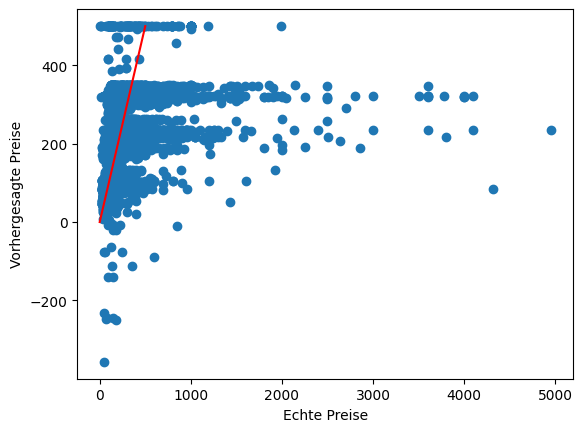

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Daten einlesen
listings = pd.read_csv('real data/listings.csv')

# filter out prices over 5000
listings = listings[listings['price'] < 5000]

# Datenvorbereitung
listings = listings.dropna(subset=['price', 'room_type', 'neighbourhood_group'])

# Merkmale und Zielvariable
X = listings[['room_type', 'neighbourhood_group', 'minimum_nights', 'number_of_reviews']]
X = pd.get_dummies(X, drop_first=True)
y = listings['price']

# Trainings- und Testdatensätze
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Lineare Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Vorhersagen und Bewertung
predictions = model.predict(X_test)
plt.scatter(y_test, predictions)
plt.xlabel("Echte Preise")
plt.ylabel("Vorhergesagte Preise")

# diagonale Linie
plt.plot([0, 500], [0, 500], color='red')

plt.show()


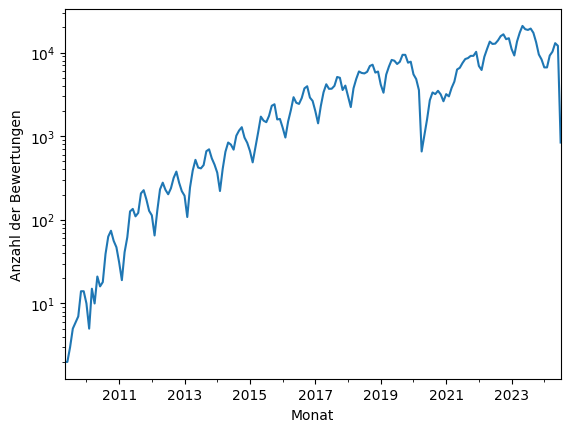

In [2]:
# Daten einlesen
reviews = pd.read_csv('real data/reviews.csv')

# Verknüpfen von Listings und Reviews
listings_reviews = pd.merge(listings, reviews, left_on='id', right_on='listing_id')

# Anzahl der Bewertungen pro Monat
listings_reviews['date'] = pd.to_datetime(listings_reviews['date'])
listings_reviews['month'] = listings_reviews['date'].dt.to_period('M')
reviews_per_month = listings_reviews.groupby('month').size()

# Plot
reviews_per_month.plot(kind='line')
plt.xlabel('Monat')
plt.ylabel('Anzahl der Bewertungen')
plt.yscale('log')
plt.show()


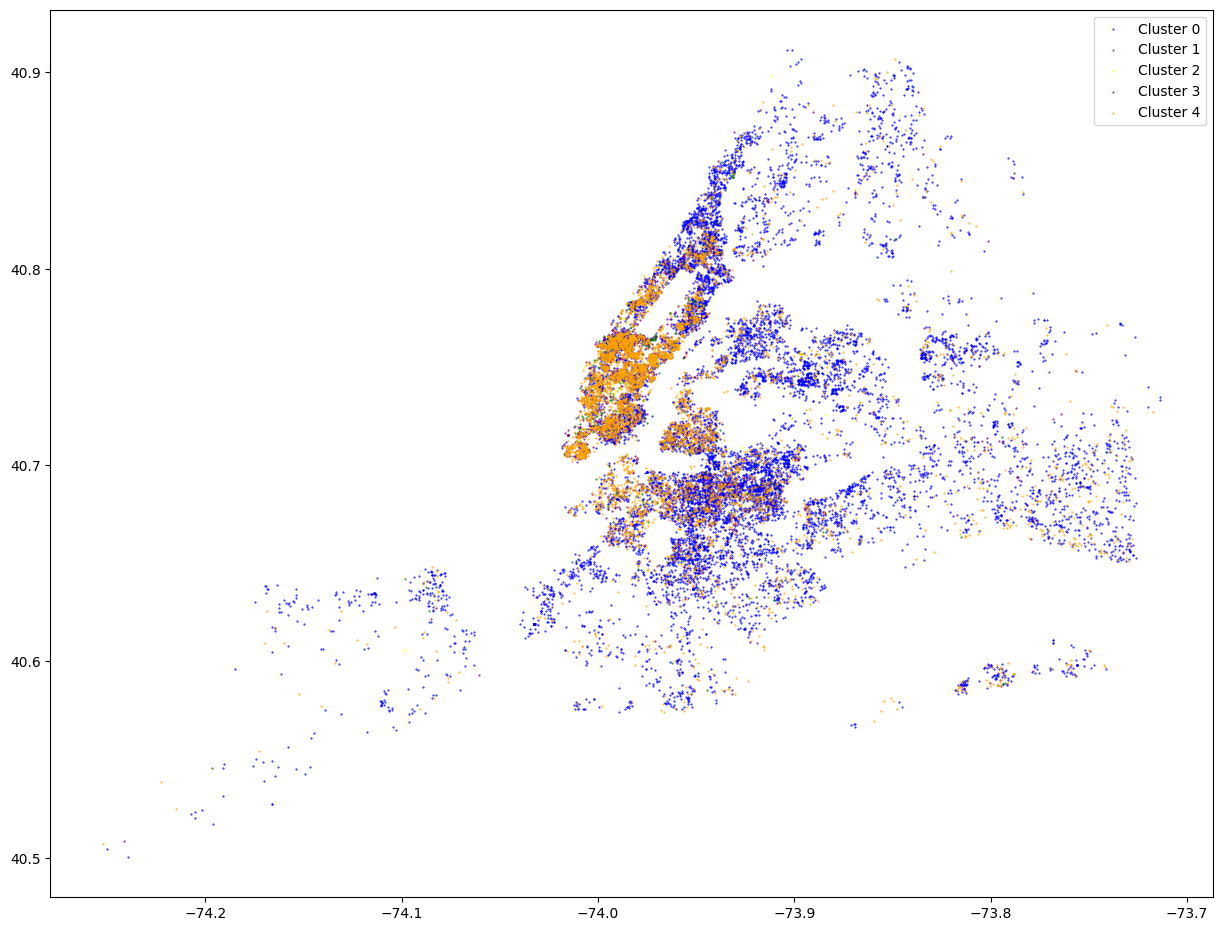

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Daten einlesen
neighbourhoods = pd.read_csv('real data/neighbourhoods.csv')

# Verknüpfen von Listings und Nachbarschaften
listings_neighbourhoods = pd.merge(listings, neighbourhoods, on='neighbourhood')

# Erstellen einer GeoDataFrame
gdf = gpd.GeoDataFrame(listings_neighbourhoods, 
                       geometry=gpd.points_from_xy(listings_neighbourhoods.longitude, listings_neighbourhoods.latitude))


# Clusteranalyse
kmeans = KMeans(n_clusters=5)
gdf['cluster'] = kmeans.fit_predict(listings_neighbourhoods[['price']])

# add price to the dataframe
gdf['price'] = listings_neighbourhoods['price']

# Plotten der Cluster


fig, ax = plt.subplots()
# size big

# gdf.plot(ax=ax, marker='o', color='red', markersize=5)
gdf[gdf['cluster'] == 0].plot(ax=ax, marker='o', color='blue',   markersize=0.2)
gdf[gdf['cluster'] == 1].plot(ax=ax, marker='o', color='green',  markersize=0.2)
gdf[gdf['cluster'] == 2].plot(ax=ax, marker='o', color='yellow', markersize=0.2)
gdf[gdf['cluster'] == 3].plot(ax=ax, marker='o', color='purple', markersize=0.2)
gdf[gdf['cluster'] == 4].plot(ax=ax, marker='o', color='orange', markersize=0.2)

# labels for cluster and its price values
plt.legend(['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3', 'Cluster 4'])
# show price ranges for each cluster


# fig size big
fig.set_size_inches(15, 15)

plt.show()



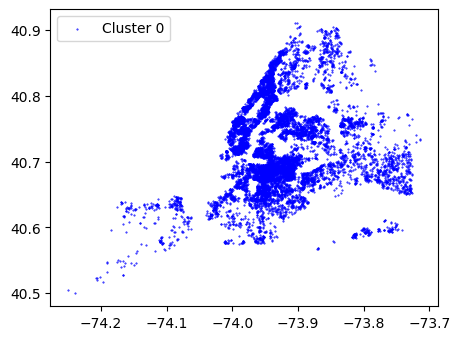

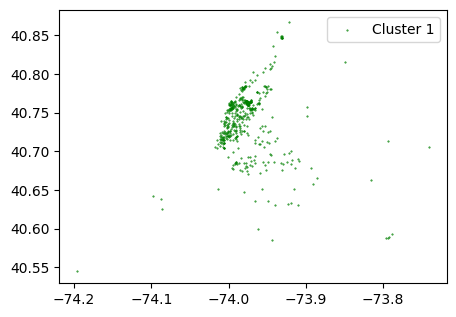

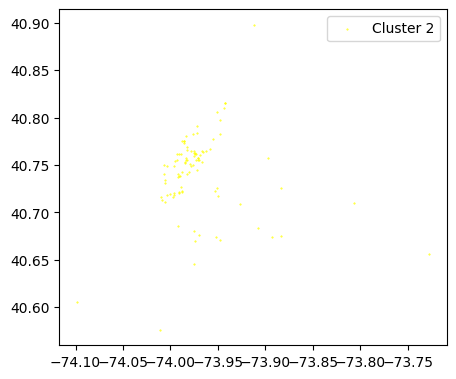

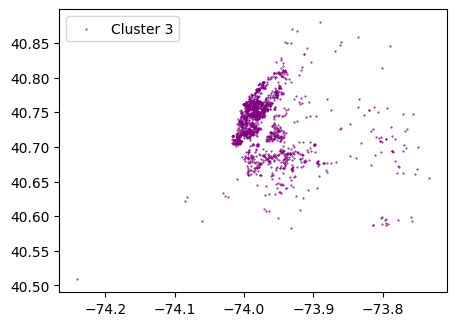

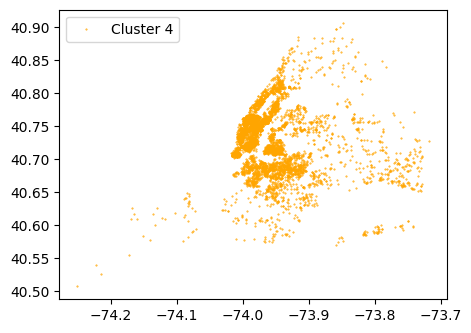

In [15]:
# make a separate plot for each cluster, but smaller
fig, ax = plt.subplots()

gdf[gdf['cluster'] == 0].plot(ax=ax, marker='o', color='blue',   markersize=0.2)
plt.legend(['Cluster 0'])
fig.set_size_inches(5, 5)
plt.show()

fig, ax = plt.subplots()
gdf[gdf['cluster'] == 1].plot(ax=ax, marker='o', color='green',  markersize=0.2)
plt.legend(['Cluster 1'])
fig.set_size_inches(5, 5)
plt.show()

fig, ax = plt.subplots()
gdf[gdf['cluster'] == 2].plot(ax=ax, marker='o', color='yellow', markersize=0.2)
plt.legend(['Cluster 2'])
fig.set_size_inches(5, 5)
plt.show()

fig, ax = plt.subplots()
gdf[gdf['cluster'] == 3].plot(ax=ax, marker='o', color='purple', markersize=0.2)
plt.legend(['Cluster 3'])
fig.set_size_inches(5, 5)
plt.show()

fig, ax = plt.subplots()
gdf[gdf['cluster'] == 4].plot(ax=ax, marker='o', color='orange', markersize=0.2)
plt.legend(['Cluster 4'])
fig.set_size_inches(5, 5)
plt.show()


In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from shapely.geometry import Point
from shapely.ops import unary_union
from collections import Counter

# Daten einlesen
listings = pd.read_csv('real data/listings.csv')
neighbourhoods = pd.read_csv('real data/neighbourhoods.csv')

# Verknüpfen von Listings und Nachbarschaften
listings_neighbourhoods = pd.merge(listings, neighbourhoods, on='neighbourhood')

# Erstellen einer GeoDataFrame
gdf = gpd.GeoDataFrame(listings_neighbourhoods,
                       geometry=gpd.points_from_xy(listings_neighbourhoods.longitude, listings_neighbourhoods.latitude))

# Clusteranalyse
kmeans = KMeans(n_clusters=5)
gdf['cluster'] = kmeans.fit_predict(listings_neighbourhoods[['price']])

# add price to the dataframe
gdf['price'] = listings_neighbourhoods['price']

# Kreise mit einem Radius von 1 km erstellen
def create_buffer(point, radius=1000):
    return point.buffer(radius)

gdf['buffer'] = gdf['geometry'].apply(create_buffer)

# Dominante Cluster in jedem Kreis bestimmen
buffers_union = unary_union(gdf['buffer'].tolist())
buffered_gdf = gpd.GeoDataFrame(geometry=[buffers_union])

# Plotten der Cluster
fig, ax = plt.subplots(figsize=(15, 15))

colors = ['blue', 'green', 'yellow', 'purple', 'orange']
for cluster in range(5):
    gdf[gdf['cluster'] == cluster].plot(ax=ax, marker='o', color=colors[cluster], markersize=5, label=f'Cluster {cluster}')

# Beschriftung der Kreise mit den dominanten Clustern und Preisspannen
for _, row in gdf.iterrows():
    buffer = row['buffer']
    points_within_buffer = gdf[gdf['geometry'].within(buffer)]
    dominant_cluster = Counter(points_within_buffer['cluster']).most_common(1)[0][0]
    price_range = (points_within_buffer['price'].min(), points_within_buffer['price'].max())

    ax.annotate(f'Cluster {dominant_cluster}\nPrice: {price_range[0]}-{price_range[1]}',
                xy=(row['geometry'].x, row['geometry'].y),
                xytext=(3, 3), textcoords='offset points', fontsize=8, color=colors[dominant_cluster])

plt.legend()
plt.show()


ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values